In [2]:
%cd ..

/data/datnt3/text-normalization


# Basic statistics

In [1]:
import os
import pandas as pd

file = "/data/datnt3/text-normalization/data_storage/train_test/2025-06-15/add_tagged_sentence_train_data.csv"

df = pd.read_csv(file)

# df.head(10)

In [2]:
len(df)

388009

In [3]:
for col in df.columns:
  print(col)

input
output
tagged_sentence
tags


In [4]:
# Tags to exclude
exclude_tags = {"dd", "roman_range", "hms", "ss", "t_mm"}

# Function to check if any tag in the row is in the exclude list
def contains_excluded_tag(tag_str):
    if pd.isna(tag_str):
        return False
    tags = [t.strip() for t in tag_str.split(";")]
    return any(tag in exclude_tags for tag in tags)

# Filter the DataFrame
df_filtered = df[~df["tags"].apply(contains_excluded_tag)].copy()


In [5]:
len(df_filtered)

387270

In [6]:
tag_counts = (
    df_filtered["tags"]
    .dropna()
    .str.split(";")
    .explode()
    .str.strip()
    .value_counts()
)

print(tag_counts)

tags
num_int           209992
dmy                75457
dm                 49372
measure            42477
num_int1           24636
num_float          17515
range              15850
tel                14832
my                  9368
score               5489
hm                  4901
measure_range       4364
currency            3913
ddm                 3750
fraction            3175
dmdm                2226
dmydmy              1974
qy                  1187
ddmy                1027
roman                913
yy                   829
math_operator        628
dmdmy                594
mymy                 449
hmhm                 414
currency_range       355
hh                   282
mmy                  277
hour                 165
ratio                 94
mm                    45
Name: count, dtype: int64


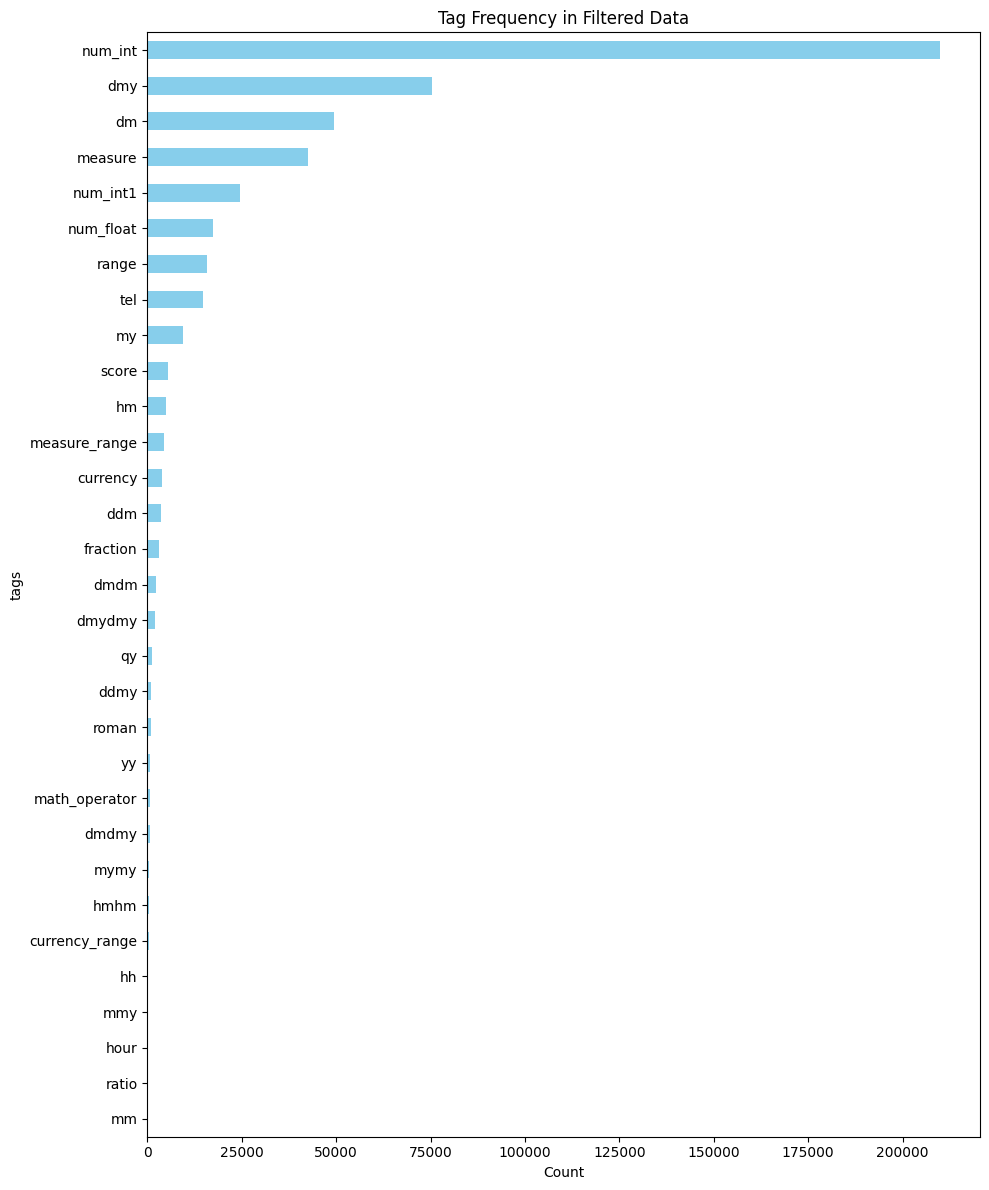

In [7]:
import matplotlib.pyplot as plt

# Calculate tag frequencies again from the filtered DataFrame
tag_counts = (
    df_filtered["tags"]
    .dropna()
    .str.split(";")
    .explode()
    .str.strip()
    .value_counts()
)

# Plot as horizontal bar chart
plt.figure(figsize=(10, 12))
tag_counts.plot(kind='barh', color='skyblue')
plt.xlabel("Count")
plt.title("Tag Frequency in Filtered Data")
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()


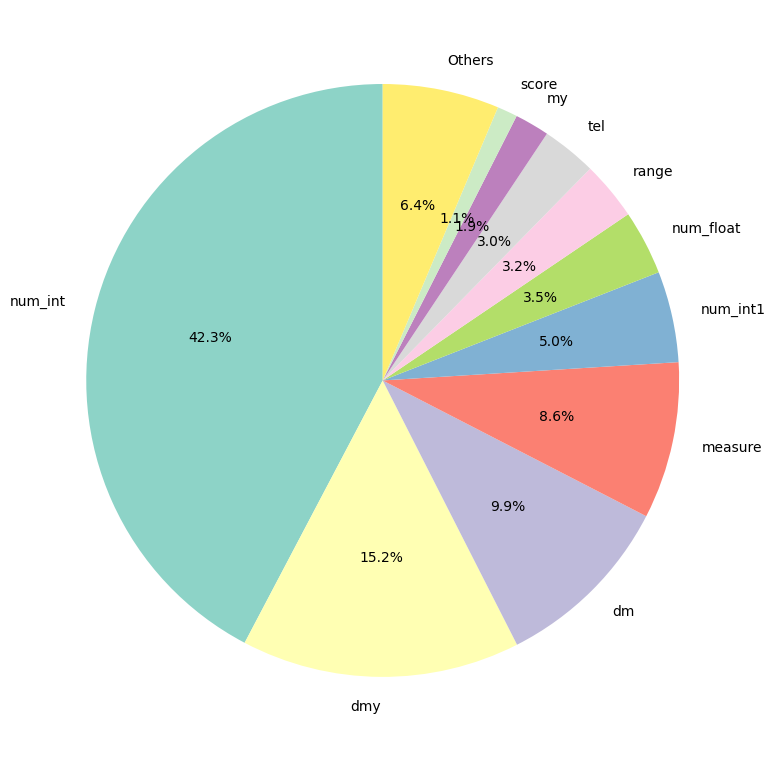

In [8]:
# Get percentages
tag_percent = (tag_counts / tag_counts.sum()) * 100

# Show only top N + group others
top_n = 10
top_tags = tag_percent.head(top_n)
top_tags["Others"] = tag_percent[top_n:].sum()

# Pie chart of percentages
plt.figure(figsize=(8, 8))
top_tags.plot.pie(autopct='%.1f%%', startangle=90, colormap='Set3')
plt.ylabel("")
# plt.title(f"Proportion of Top {top_n} Tags (%)")
plt.tight_layout()
plt.show()


In [10]:
# Add length columns
df_filtered["input_char_len"] = df_filtered["input"].str.len()
df_filtered["input_word_len"] = df_filtered["input"].str.split().apply(len)


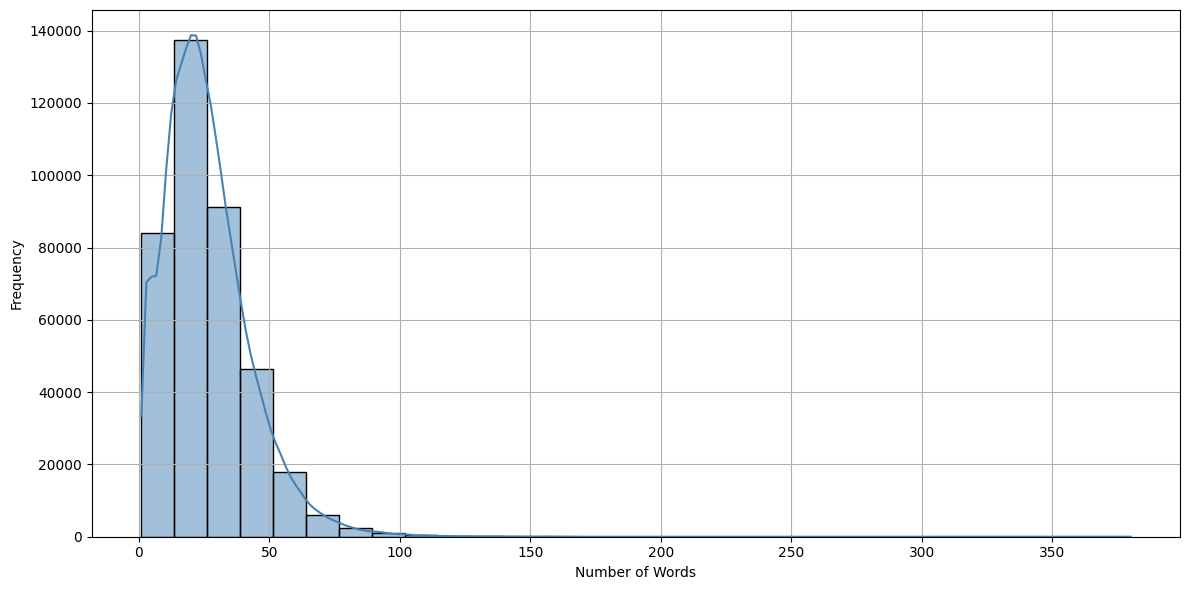

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Word length distribution
sns.histplot(df_filtered["input_word_len"], bins=30, kde=True, color='steelblue')
# plt.title("Distribution of Sentence Lengths (by Words) in 'input'")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

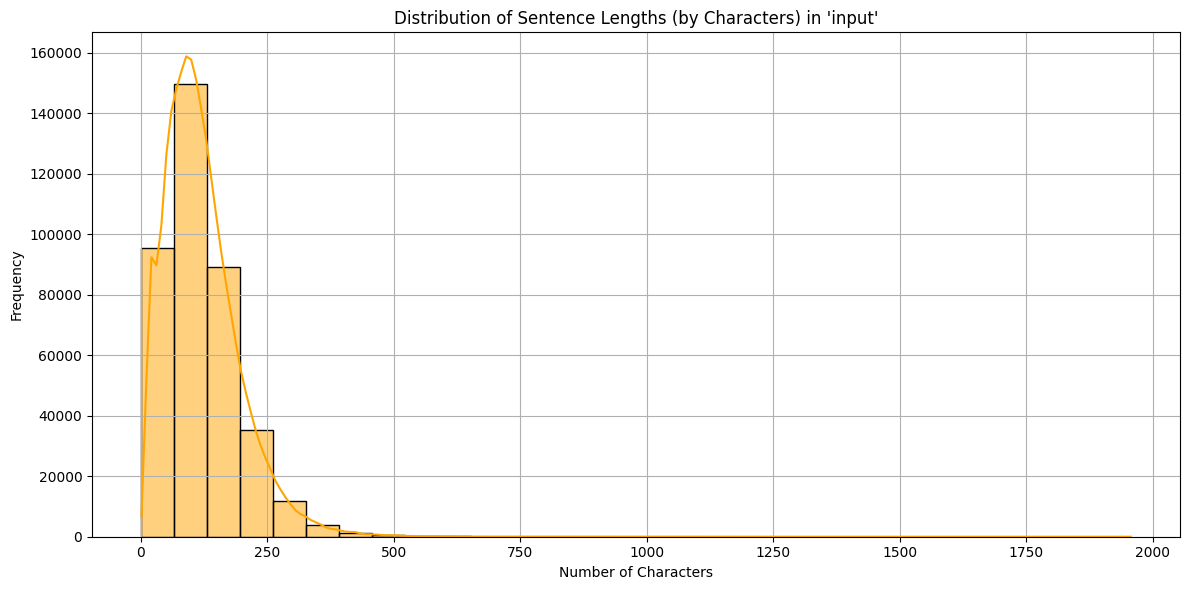

In [42]:
plt.figure(figsize=(12, 6))

sns.histplot(df_filtered["input_char_len"], bins=30, kde=True, color='orange')
plt.title("Distribution of Sentence Lengths (by Characters) in 'input'")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
print("Word length stats:")
print(df_filtered["input_word_len"].describe())

print("\nCharacter length stats:")
print(df_filtered["input_char_len"].describe())


Word length stats:
count    387270.000000
mean         26.339006
std          16.397132
min           1.000000
25%          15.000000
50%          24.000000
75%          35.000000
max         380.000000
Name: input_word_len, dtype: float64

Character length stats:
count    387270.000000
mean        119.970085
std          74.135057
min           1.000000
25%          67.000000
50%         108.000000
75%         158.000000
max        1956.000000
Name: input_char_len, dtype: float64


In [44]:
import re

def get_all_matches(sentence: str):
        pattern = r'~([^~#]+?)#(currency_range|math_operator|measure_range|hour_measure|roman_range|num_float|currency|num_int1|fraction|measure|num_int|num\/num|num-num|num\.num|num\:num|dmydmy|hmshms|dmdmy|range|roman|score|ratio|ddmy|dmdm|mymy|hmhm|msms|t_mm|hour|dmy|mmy|qqy|ddm|hms|tel|qq|dd|mm|yy|my|dm|qy|hh|ss|hm|ms)'
        matches = re.finditer(pattern, sentence)
        
        return [match for match in matches]

In [13]:
import pandas as pd
import re
from collections import Counter
from itertools import islice

# Define regex match function
def get_all_matches(sentence: str):
    pattern = r'~([^~#]+?)#(currency_range|math_operator|measure_range|hour_measure|roman_range|num_float|currency|num_int1|fraction|measure|num_int|num\/num|num-num|num\.num|num\:num|dmydmy|hmshms|dmdmy|range|roman|score|ratio|ddmy|dmdm|mymy|hmhm|msms|t_mm|hour|dmy|mmy|qqy|ddm|hms|tel|qq|dd|mm|yy|my|dm|qy|hh|ss|hm|ms)'
    matches = re.finditer(pattern, sentence)
    return [match.group(2) for match in matches]  # only return the type

# This ensures every row gets a list (even if it's empty)
df_filtered["nsw_types"] = df_filtered["tagged_sentence"].apply(
    lambda x: get_all_matches(x) if isinstance(x, str) else []
)

df_filtered["nsw_count"] = df_filtered["nsw_types"].apply(len)




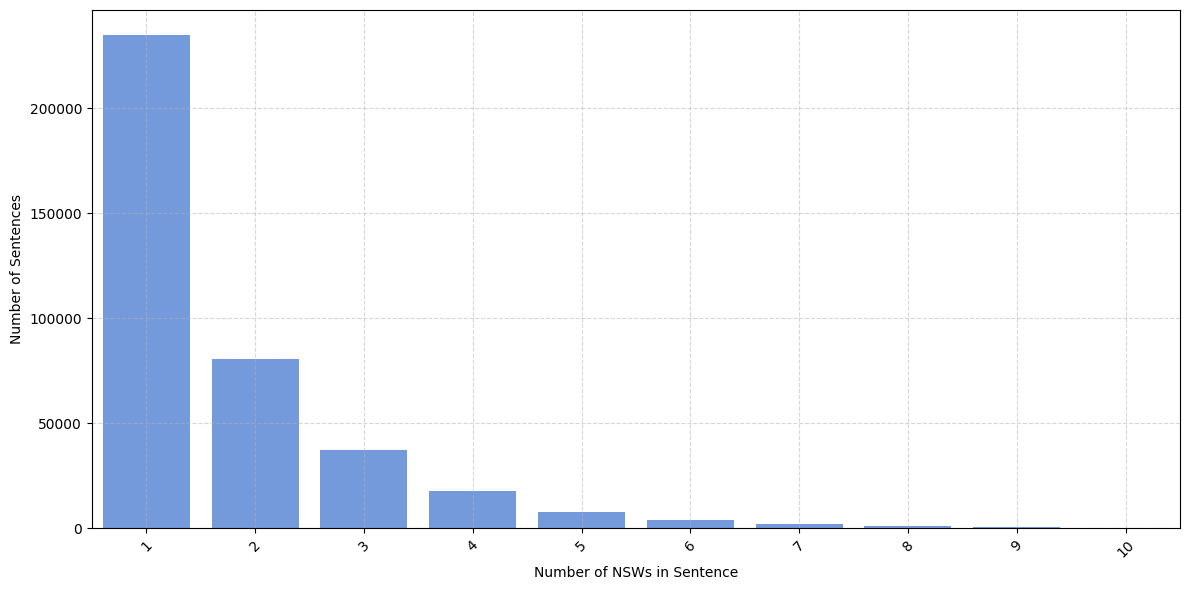

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(x="nsw_count", data=df_filtered[df_filtered["nsw_count"] <= 10], color="cornflowerblue")
# plt.title("Distribution of NSW Counts per Sentence")
plt.xlabel("Number of NSWs in Sentence")
plt.ylabel("Number of Sentences")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


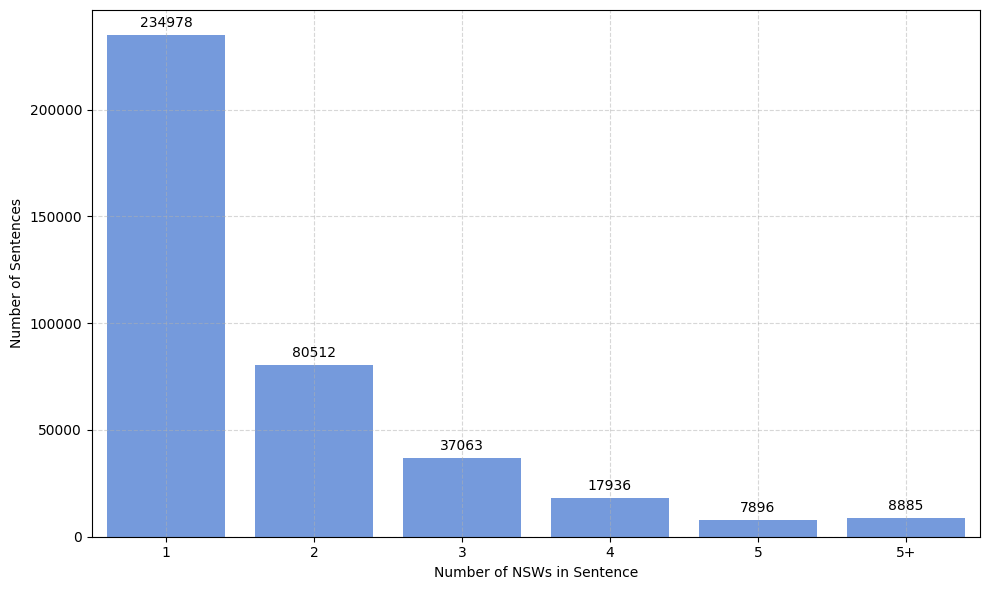

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Create a new capped column
df_filtered["nsw_count_capped"] = df_filtered["nsw_count"].apply(lambda x: x if x <= 5 else "5+")

# Step 2: Count values
count_data = df_filtered["nsw_count_capped"].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors='coerce').fillna(999))

# Step 3: Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=count_data.index.astype(str), y=count_data.values, color="cornflowerblue")

# Add labels on top of bars
for i, val in enumerate(count_data.values):
    ax.text(i, val + max(count_data.values) * 0.01, str(val), ha='center', va='bottom', fontsize=10)

plt.xlabel("Number of NSWs in Sentence")
plt.ylabel("Number of Sentences")
# plt.title("Distribution of NSW Counts (Capped at 6+)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [51]:
# Create summary table
nsw_count_table = df_filtered["nsw_count"].value_counts().sort_index().reset_index()
nsw_count_table.columns = ["NSW Count", "Number of Sentences"]
print(nsw_count_table)


    NSW Count  Number of Sentences
0           1               234978
1           2                80512
2           3                37063
3           4                17936
4           5                 7896
5           6                 3988
6           7                 2039
7           8                 1018
8           9                  528
9          10                  377
10         11                  201
11         12                  141
12         13                  105
13         14                   90
14         15                   64
15         16                   52
16         17                   36
17         18                   23
18         19                   21
19         20                   15
20         21                    5
21         22                   16
22         23                    8
23         24                    8
24         25                    4
25         26                    4
26         27                    2
27         28       

In [19]:
from nltk.util import ngrams
from collections import Counter

def extract_ngrams(nsw_list_col, n):
    ngram_counter = Counter()
    for tags in nsw_list_col:
        if len(tags) >= n:
            ngram_counter.update(ngrams(tags, n))
    return ngram_counter

# Unigram, bigram, trigram
unigrams = extract_ngrams(df_filtered["nsw_types"], 1)
bigrams = extract_ngrams(df_filtered["nsw_types"], 2)
trigrams = extract_ngrams(df_filtered["nsw_types"], 3)

# Convert to DataFrame for visualization
def counter_to_df_filtered(counter, name):
    df_filtered = pd.DataFrame(counter.items(), columns=[name, 'count']).sort_values(by='count', ascending=False)
    return df_filtered

df_filtered_uni = counter_to_df_filtered(unigrams, 'unigram')
df_filtered_bi = counter_to_df_filtered(bigrams, 'bigram')
df_filtered_tri = counter_to_df_filtered(trigrams, 'trigram')


In [20]:
# Display top 10 of each
print("🔹 Top 10 Unigrams:")
print(df_filtered_uni.head(10))

print("\n🔹 Top 10 Bigrams:")
print(df_filtered_bi.head(10))

print("\n🔹 Top 10 Trigrams:")
print(df_filtered_tri.head(10))


🔹 Top 10 Unigrams:
         unigram   count
0     (num_int,)  361734
3         (dmy,)   75458
1     (measure,)   58670
8          (dm,)   53521
2    (num_int1,)   32941
5   (num_float,)   22753
9       (range,)   19995
4         (tel,)   14830
10         (my,)   10016
14      (score,)    7588

🔹 Top 10 Bigrams:
                  bigram   count
2     (num_int, num_int)  132204
13         (dm, num_int)   17990
0     (num_int, measure)   15885
6     (measure, num_int)   12477
18         (num_int, dm)   11997
5     (measure, measure)   11857
3    (num_int, num_int1)    9221
4    (num_int1, num_int)    7458
8   (num_int, num_float)    7187
7   (num_int1, num_int1)    5561

🔹 Top 10 Trigrams:
                         trigram  count
1    (num_int, num_int, num_int)  52841
12        (dm, num_int, num_int)   6876
9    (num_int, measure, num_int)   4296
13   (num_int, num_int, measure)   4194
48        (num_int, dm, num_int)   3684
101  (measure, measure, measure)   3460
6    (measure, num_int, 

/tmp/ipykernel_3434699/2538891552.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df_filtered_uni["unigram"].head(10).astype(str), x=df_filtered_uni["count"].head(10), palette="viridis")


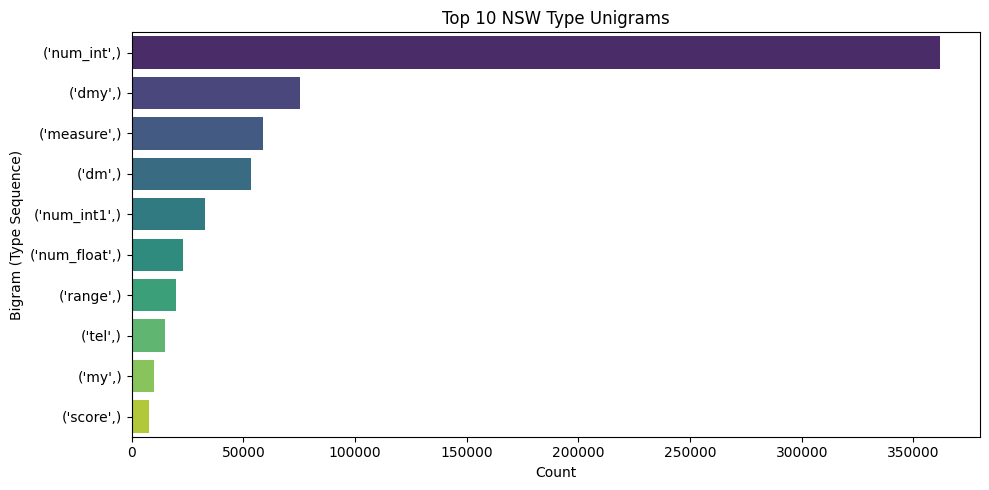

/tmp/ipykernel_3434699/2538891552.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df_filtered_bi["bigram"].head(10).astype(str), x=df_filtered_bi["count"].head(10), palette="viridis")


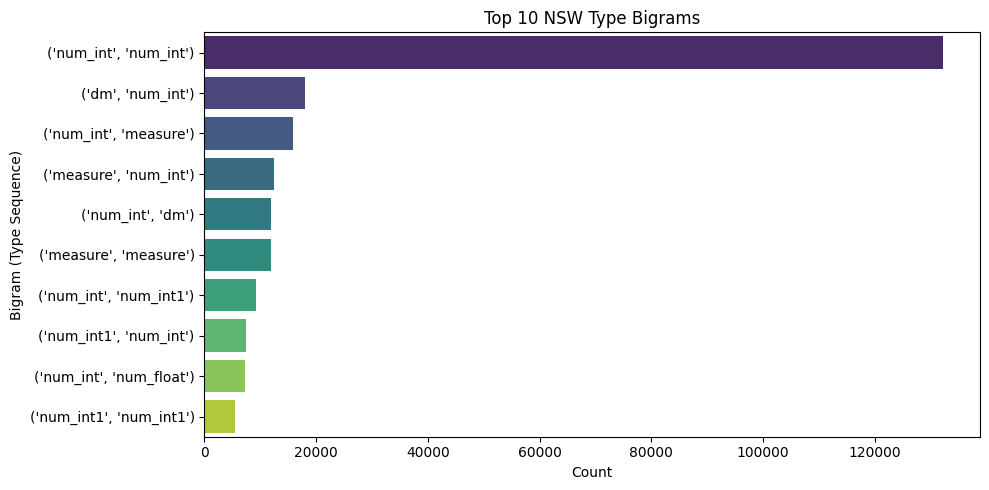

/tmp/ipykernel_3434699/2538891552.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df_filtered_tri["trigram"].head(10).astype(str), x=df_filtered_tri["count"].head(10), palette="viridis")


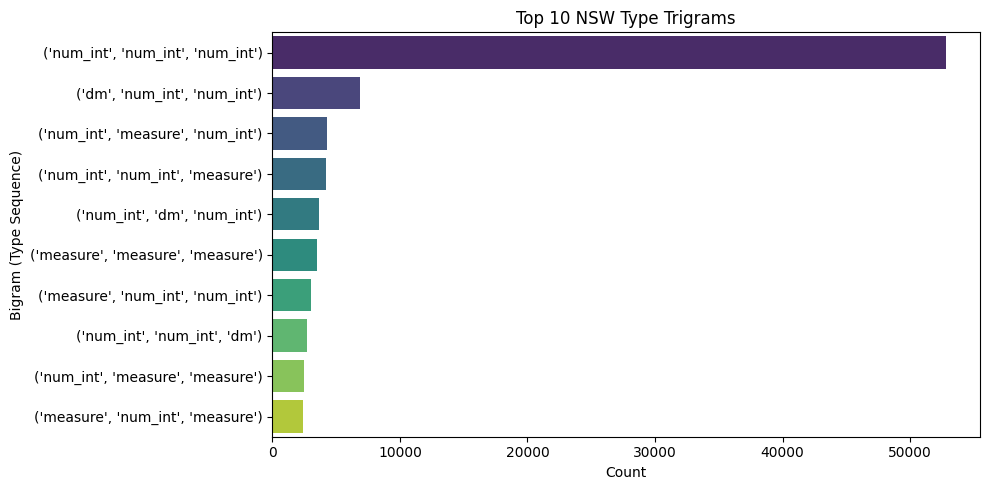

In [61]:
# Plot top 10 bigrams
plt.figure(figsize=(10, 5))
sns.barplot(y=df_filtered_uni["unigram"].head(10).astype(str), x=df_filtered_uni["count"].head(10), palette="viridis")
plt.title("Top 10 NSW Type Unigrams")
plt.xlabel("Count")
plt.ylabel("Bigram (Type Sequence)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(y=df_filtered_bi["bigram"].head(10).astype(str), x=df_filtered_bi["count"].head(10), palette="viridis")
plt.title("Top 10 NSW Type Bigrams")
plt.xlabel("Count")
plt.ylabel("Bigram (Type Sequence)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(y=df_filtered_tri["trigram"].head(10).astype(str), x=df_filtered_tri["count"].head(10), palette="viridis")
plt.title("Top 10 NSW Type Trigrams")
plt.xlabel("Count")
plt.ylabel("Bigram (Type Sequence)")
plt.tight_layout()
plt.show()



/tmp/ipykernel_104558/3013374092.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


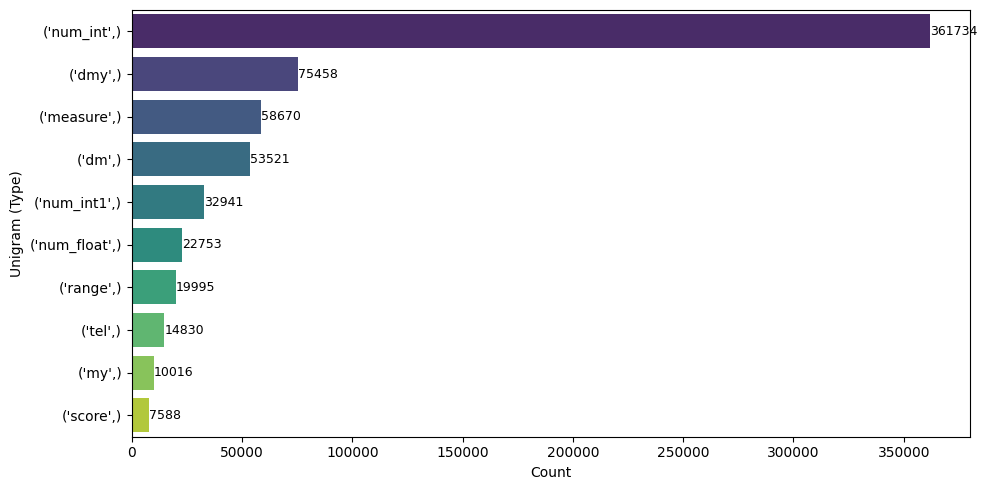

/tmp/ipykernel_104558/3013374092.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


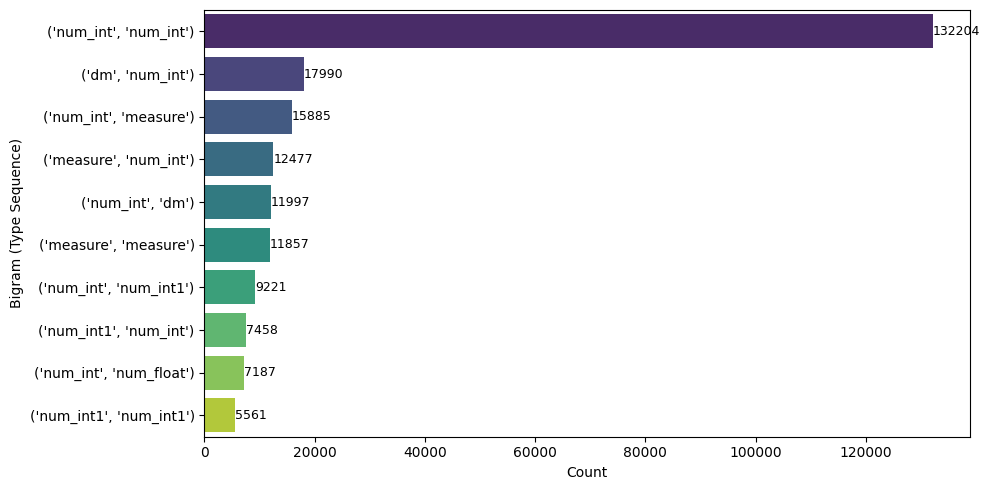

/tmp/ipykernel_104558/3013374092.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


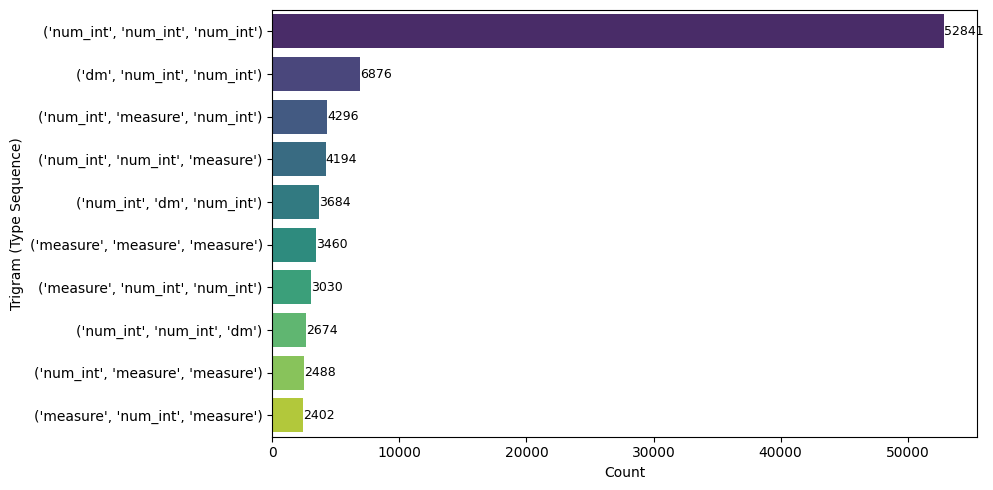

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unigram
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    y=df_filtered_uni["unigram"].head(10).astype(str),
    x=df_filtered_uni["count"].head(10),
    palette="viridis"
)
for i, val in enumerate(df_filtered_uni["count"].head(10)):
    ax.text(val + 1, i, str(val), va="center", fontsize=9)
# plt.title("Top 10 NSW Type Unigrams")
plt.xlabel("Count")
plt.ylabel("Unigram (Type)")
plt.tight_layout()
plt.show()

# Bigram
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    y=df_filtered_bi["bigram"].head(10).astype(str),
    x=df_filtered_bi["count"].head(10),
    palette="viridis"
)
for i, val in enumerate(df_filtered_bi["count"].head(10)):
    ax.text(val + 1, i, str(val), va="center", fontsize=9)
# plt.title("Top 10 NSW Type Bigrams")
plt.xlabel("Count")
plt.ylabel("Bigram (Type Sequence)")
plt.tight_layout()
plt.show()

# Trigram
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    y=df_filtered_tri["trigram"].head(10).astype(str),
    x=df_filtered_tri["count"].head(10),
    palette="viridis"
)
for i, val in enumerate(df_filtered_tri["count"].head(10)):
    ax.text(val + 1, i, str(val), va="center", fontsize=9)
# plt.title("Top 10 NSW Type Trigrams")
plt.xlabel("Count")
plt.ylabel("Trigram (Type Sequence)")
plt.tight_layout()
plt.show()


# Test Dataset


In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt

file = "/data/datnt3/text-normalization/data_storage/train_test/2025-05-25/test_data_main.csv"

df = pd.read_csv(file)

In [3]:
len(df)

1189

In [4]:
for col in df.columns:
  print(col)

input
s_output
tagged_sentence
tags
gpt_tagged_sentence
gpt_tags
final_tags
test_tag


In [6]:
tag_counts = (
    df["final_tags"]
    .dropna()
    .str.split(";")
    .explode()
    .str.strip()
    .value_counts()
)

print(tag_counts)

final_tags
num_int           599
dm                172
measure           145
num_int1          110
range              81
num_float          71
my                 67
dmy                66
currency           58
hm                 57
measure_range      57
roman              52
dmydmy             50
tel                49
dmdm               49
qy                 49
ddm                48
score              47
hh                 44
currency_range     42
ddmy               40
yy                 40
math_operator      39
fraction           38
dmdmy              18
mymy               15
hmhm               14
ratio              13
mmy                11
mm                 10
hour                8
Name: count, dtype: int64


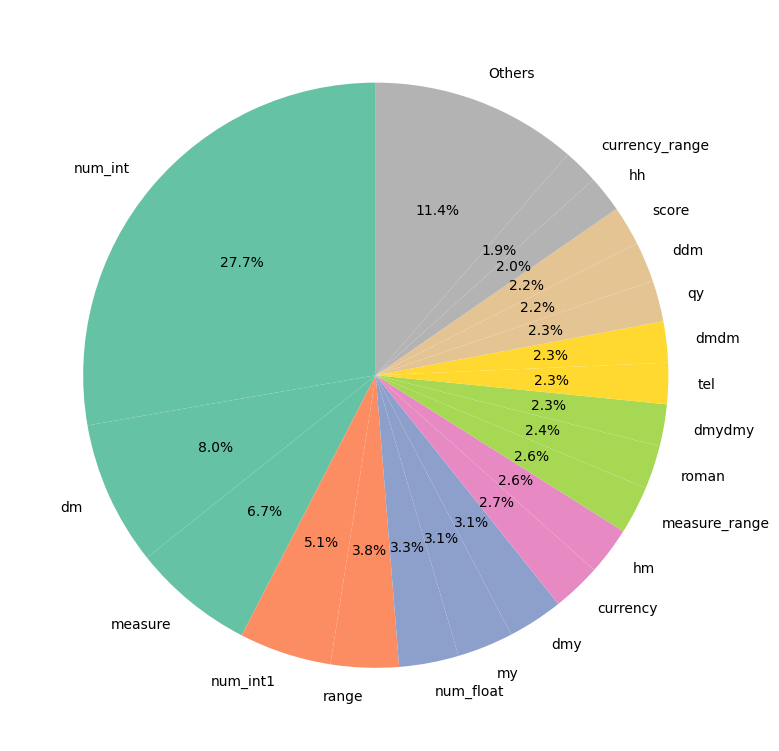

In [16]:
# Get percentages
tag_percent = (tag_counts / tag_counts.sum()) * 100

# Show only top N + group others
top_n = 20
top_tags = tag_percent.head(top_n)
top_tags["Others"] = tag_percent[top_n:].sum()

# Pie chart of percentages
plt.figure(figsize=(8, 8))
top_tags.plot.pie(autopct='%.1f%%', startangle=90, colormap='Set2')
plt.ylabel("")
# plt.title(f"Proportion of Top {top_n} Tags (%)")
plt.tight_layout()
plt.show()


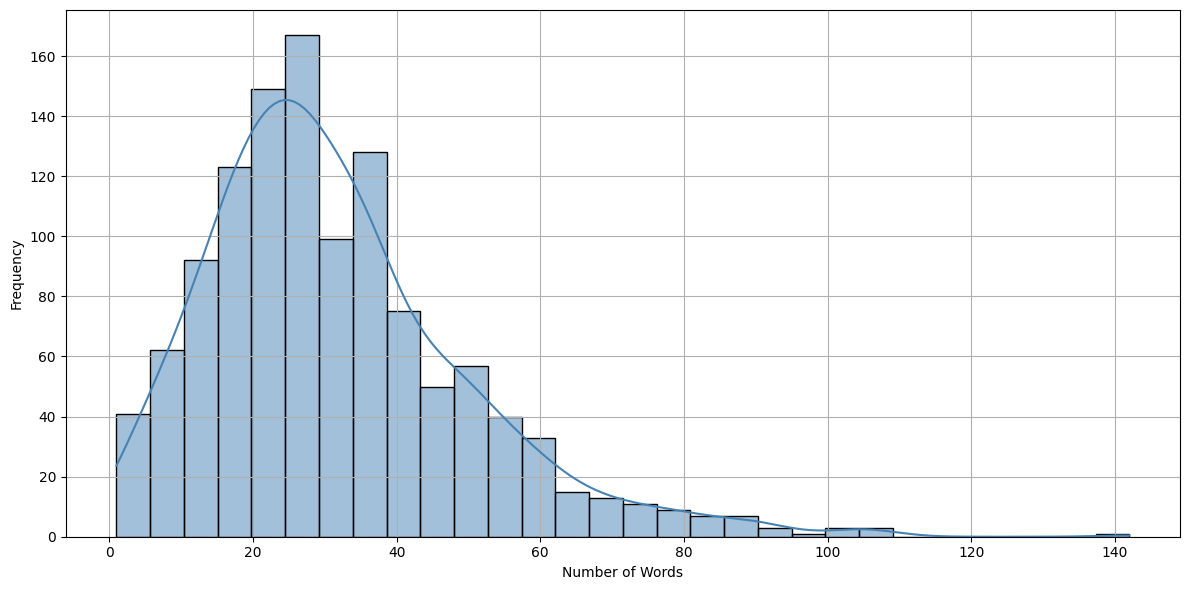

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add length columns
df["input_char_len"] = df["input"].str.len()
df["input_word_len"] = df["input"].str.split().apply(len)


plt.figure(figsize=(12, 6))

# Word length distribution
sns.histplot(df["input_word_len"], bins=30, kde=True, color='steelblue')
# plt.title("Distribution of Sentence Lengths (by Words) in 'input'")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
print("Word length stats:")
print(df["input_word_len"].describe())

Word length stats:
count    1189.000000
mean       31.619849
std        18.377682
min         1.000000
25%        19.000000
50%        28.000000
75%        40.000000
max       142.000000
Name: input_word_len, dtype: float64


In [22]:
import pandas as pd
import re
from collections import Counter
from itertools import islice

# Define regex match function
def get_all_matches(sentence: str):
    pattern = r'~([^~#]+?)#(currency_range|math_operator|measure_range|hour_measure|roman_range|num_float|currency|num_int1|fraction|measure|num_int|num\/num|num-num|num\.num|num\:num|dmydmy|hmshms|dmdmy|range|roman|score|ratio|ddmy|dmdm|mymy|hmhm|msms|t_mm|hour|dmy|mmy|qqy|ddm|hms|tel|qq|dd|mm|yy|my|dm|qy|hh|ss|hm|ms)'
    matches = re.finditer(pattern, sentence)
    return [match.group(2) for match in matches]  # only return the type

# This ensures every row gets a list (even if it's empty)
df["nsw_types"] = df["tagged_sentence"].apply(
    lambda x: get_all_matches(x) if isinstance(x, str) else []
)

df["nsw_count"] = df["nsw_types"].apply(len)




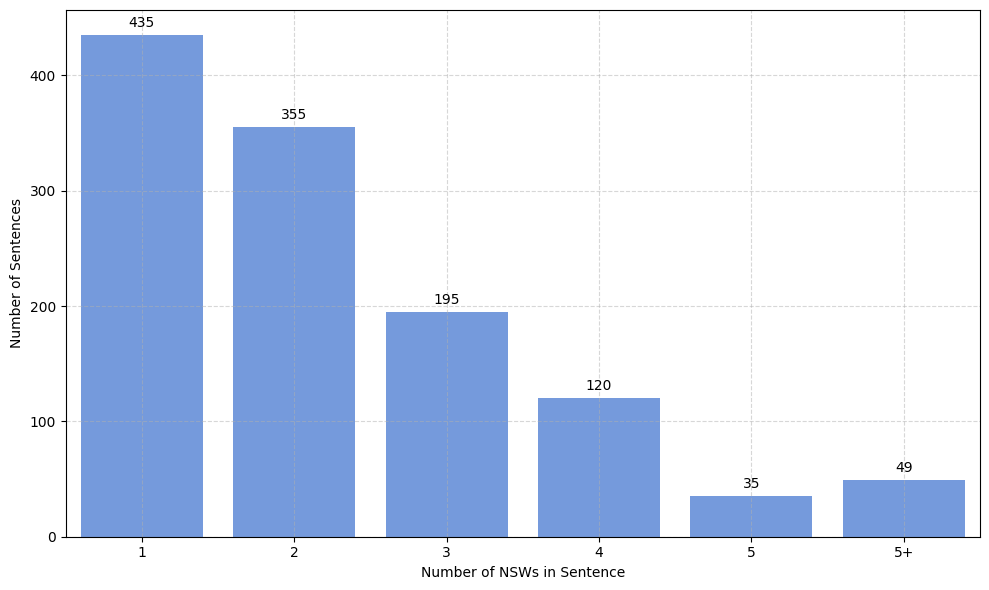

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Create a new capped column
df["nsw_count_capped"] = df["nsw_count"].apply(lambda x: x if x <= 5 else "5+")

# Step 2: Count values
count_data = df["nsw_count_capped"].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors='coerce').fillna(999))

# Step 3: Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=count_data.index.astype(str), y=count_data.values, color="cornflowerblue")

# Add labels on top of bars
for i, val in enumerate(count_data.values):
    ax.text(i, val + max(count_data.values) * 0.01, str(val), ha='center', va='bottom', fontsize=10)

plt.xlabel("Number of NSWs in Sentence")
plt.ylabel("Number of Sentences")
# plt.title("Distribution of NSW Counts (Capped at 6+)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
